## Data Preprocessing

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned dataset
df = pd.read_csv("data/cleaned_medical_appointment_data.csv")

In [3]:
# Split dataset into features and target variable, create training and testing sets with an 80-20 split
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['no_show'])
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 999)

In [4]:
# Convert gender categorical variable into separate 'male' and 'female' columns using one hot encoding
X_train = pd.get_dummies(X_train, columns = ['gender'], prefix = '', prefix_sep = '')
X_train['male'] = X_train['male'].astype('int64')
X_train['female'] = X_train['female'].astype('int64')
X_test = pd.get_dummies(X_test, columns = ['gender'], prefix = '', prefix_sep = '')
X_test['male'] = X_test['male'].astype('int64')
X_test['female'] = X_test['female'].astype('int64')
X_train, X_test = X_train.align(X_test, join = 'left', axis = 1, fill_value = 0)

In [5]:
# Apply log transformation to age, scale it using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train['age'] = np.log1p(X_train['age'])
X_train['age'] = scaler.fit_transform(X_train[['age']])
X_test['age'] = np.log1p(X_test['age'])
X_test['age'] = scaler.transform(X_test[['age']])

In [6]:
# Combine less frequent neighborhoods into one category
neighborhood_mapping = {neighborhood: neighborhood if count >= 50 else 'Other' for neighborhood, count in X_train['neighborhood'].value_counts().items()}

X_train['neighborhood'] = X_train['neighborhood'].map(neighborhood_mapping)
X_test['neighborhood'] = X_test['neighborhood'].map(neighborhood_mapping)

In [7]:
# Apply binary encoding to the neighborhood feature
import category_encoders as ce

encoder = ce.BinaryEncoder(cols = ['neighborhood'])
train_neighborhoods = encoder.fit_transform(X_train['neighborhood'])
X_train = pd.concat([X_train.drop('neighborhood', axis = 1), train_neighborhoods], axis = 1)
test_neighborhoods = encoder.fit_transform(X_test['neighborhood'])
X_test = pd.concat([X_test.drop('neighborhood', axis = 1), test_neighborhoods], axis = 1)

In [8]:
# Convert appointment month into separate 'april', 'may', and 'june' columns using one hot encoding
train_months = pd.get_dummies(X_train['appointment_month'], prefix = '', drop_first = False).astype('int64')
train_months.columns = ['april', 'may', 'june']
X_train = pd.concat([X_train.drop('appointment_month', axis = 1), train_months], axis = 1)
test_months = pd.get_dummies(X_test['appointment_month'], prefix = '', drop_first = False).astype('int64')
test_months.columns = ['april', 'may', 'june']
X_test = pd.concat([X_test.drop('appointment_month', axis = 1), test_months], axis = 1)

In [9]:
# Convert appointment day of week into separate columns using one hot encoding
train_days_of_week = pd.get_dummies(X_train['appointment_day_of_week'], prefix = '', drop_first = False).astype('int64')
train_days_of_week.columns = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
X_train = pd.concat([X_train.drop('appointment_day_of_week', axis = 1), train_days_of_week], axis = 1)
test_days_of_week = pd.get_dummies(X_test['appointment_day_of_week'], prefix = '', drop_first = False).astype('int64')
test_days_of_week.columns = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
X_test = pd.concat([X_test.drop('appointment_day_of_week', axis = 1), test_days_of_week], axis = 1)

In [10]:
# Apply log transformation to previous number of patient no shows, scale it using MinMaxScaler
X_train['previous_no_shows'] = np.log1p(X_train['previous_no_shows'])
X_train['previous_no_shows'] = scaler.fit_transform(X_train[['previous_no_shows']])
X_test['previous_no_shows'] = np.log1p(X_test['previous_no_shows'])
X_test['previous_no_shows'] = scaler.transform(X_test[['previous_no_shows']])

In [11]:
# Apply log transformation to difference between scheduled day and appointment day, scale it using MinMaxScaler
X_train['day_difference'] = np.log1p(X_train['day_difference'])
X_train['day_difference'] = scaler.fit_transform(X_train[['day_difference']])
X_test['day_difference'] = np.log1p(X_test['day_difference'])
X_test['day_difference'] = scaler.transform(X_test[['day_difference']])

## Model Training and Evaluation

### Logistic Regression

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters: {'C': 100, 'penalty': 'l1'}

Test Metrics Across Classification Thresholds:
Threshold 0.3 - Accuracy 0.740, Precision 0.566, Recall 0.705, F1 Score 0.627, AUC-ROC 0.731
Threshold 0.4 - Accuracy 0.777, Precision 0.648, Recall 0.619, F1 Score 0.633, AUC-ROC 0.734
Threshold 0.5 - Accuracy 0.798, Precision 0.737, Recall 0.545, F1 Score 0.626, AUC-ROC 0.729
Threshold 0.6 - Accuracy 0.805, Precision 0.823, Recall 0.475, F1 Score 0.602, AUC-ROC 0.715
Threshold 0.7 - Accuracy 0.792, Precision 0.884, Recall 0.381, F1 Score 0.532, AUC-ROC 0.679
Threshold 0.8 - Accuracy 0.764, Precision 0.938, Recall 0.257, F1 Score 0.404, AUC-ROC 0.625


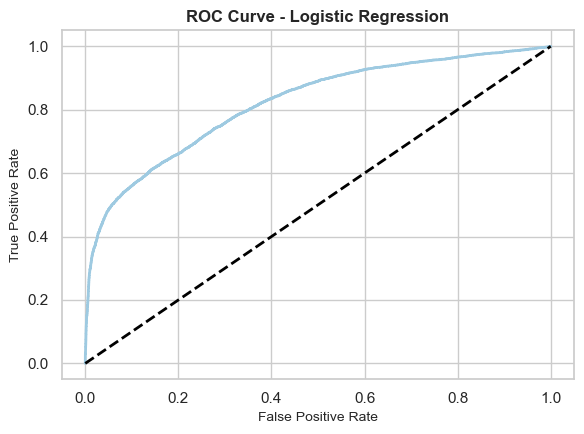

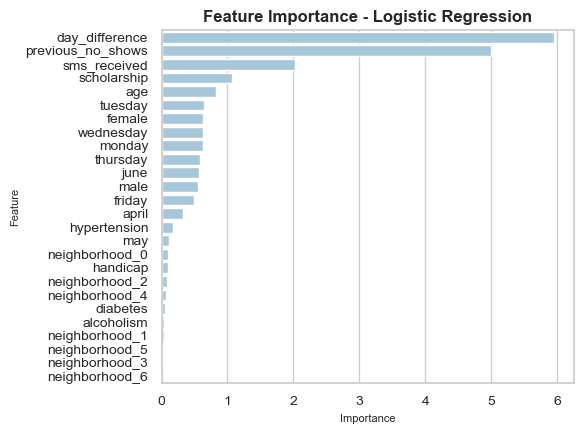

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Initialize logistic regression model
lr = LogisticRegression(solver = 'liblinear', random_state = 999)

# Define hyperparameter grid
parameter_options = {
    'C': [0.0001, 0.001, 0.005, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1', 'l2']
}

# Initialize k-fold cross-validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 999)

# Perform grid search
grid_search = GridSearchCV(
    estimator = lr,
    param_grid = parameter_options,
    cv = kf,
    scoring = 'f1',
    verbose = 1,
    n_jobs = -1
)

# Fit model and get best model
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print("\nBest Hyperparameters:", grid_search.best_params_)

# Make predictions on the test set
proba = best_lr.predict_proba(X_test)[:, 1]

# Evaluate metrics across different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print("\nTest Metrics Across Classification Thresholds:")
for threshold in thresholds:
    y_pred = (proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    if threshold == 0.5:
        print(f"\033[31mThreshold {threshold:.1f} - Accuracy {accuracy:.3f}, "
              f"Precision {precision:.3f}, Recall {recall:.3f}, "
              f"F1 Score {f1:.3f}, AUC-ROC {auc_roc:.3f}\033[0m")
    else:
        print(f"Threshold {threshold:.1f} - Accuracy {accuracy:.3f}, "
              f"Precision {precision:.3f}, Recall {recall:.3f}, "
              f"F1 Score {f1:.3f}, AUC-ROC {auc_roc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
sns.set(style = "whitegrid")
plt.figure(figsize = (6, 4.5))

plt.plot(fpr, tpr, color = '#9ECAE1', linewidth = 2, label = f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--', linewidth = 2)
plt.title('ROC Curve - Logistic Regression', fontsize = 12, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 10)
plt.ylabel('True Positive Rate', fontsize = 10)

plt.tight_layout()
plt.show()

# Get feature importance
importance = np.abs(best_lr.coef_[0])
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

# Plot feature importance
plt.figure(figsize = (6, 4.5))
sns.barplot(data = importance_df, x = 'Importance', y = 'Feature', color = '#9ECAE1', legend = False)
plt.title('Feature Importance - Logistic Regression', fontsize = 12, weight = 'bold')
plt.xlabel('Importance', fontsize = 8)
plt.ylabel('Feature', fontsize = 8)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.tight_layout()
plt.show()

### Deep Neural Network

553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step

Test Metrics Across Classification Thresholds:
Threshold 0.3 - Accuracy 0.695, Precision 0.505, Recall 0.827, F1 Score 0.627, AUC-ROC 0.731
Threshold 0.4 - Accuracy 0.825, Precision 0.831, Recall 0.549, F1 Score 0.661, AUC-ROC 0.749
Threshold 0.5 - Accuracy 0.829, Precision 0.888, Recall 0.515, F1 Score 0.652, AUC-ROC 0.743
Threshold 0.6 - Accuracy 0.831, Precision 0.933, Recall 0.489, F1 Score 0.642, AUC-ROC 0.737
Threshold 0.7 - Accuracy 0.827, Precision 0.961, Recall 0.463, F1 Score 0.625, AUC-ROC 0.727
Threshold 0.8 - Accuracy 0.820, Precision 0.981, Recall 0.429, F1 Score 0.597, AUC-ROC 0.713


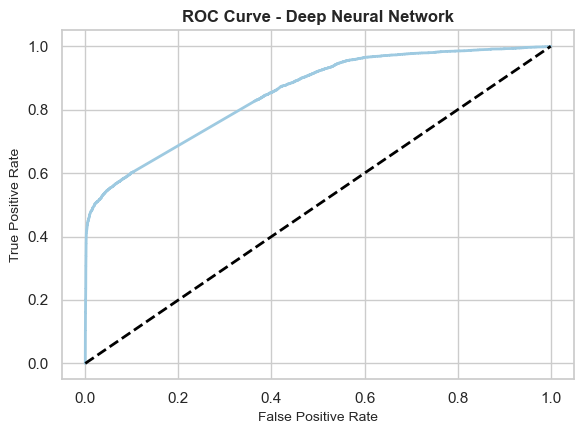

In [13]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.inspection import permutation_importance

# Function to create neural network
def create_model():
    model = Sequential()
    # Input layer
    model.add(Input(shape = (X_train.shape[1],)))  
    
    # First hidden layer
    model.add(Dense(64, activation = 'relu'))      
    model.add(Dropout(0.4))
    
    # Second hidden layer
    model.add(Dense(32, activation = 'relu'))      
    model.add(Dropout(0.4))
    
    # Output layer
    model.add(Dense(1, activation = 'sigmoid'))    
    model.compile(optimizer = Adam(learning_rate = 0.01), 
                  loss = 'binary_crossentropy', 
                  metrics = ['AUC'])
    return model

# Initialize stratified k-fold
skf = StratifiedKFold(n_splits = 5)

# Track best model and associated score
best_dnn = None
best_f1 = 0

# Loop through each fold
for train_index, test_index in skf.split(X_train, y_train):
    X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = create_model()
    model.fit(X_train_k, y_train_k, epochs = 50, batch_size = 32, verbose = 0)
    
    y_pred_class_k = (model.predict(X_test_k) > 0.5).astype(int)
    f1 = f1_score(y_test_k, y_pred_class_k)

    if f1 > best_f1:
        best_f1 = f1
        best_dnn = model

# Make predictions on the test set
proba = best_dnn.predict(X_test)

# Evaluate metrics across different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print("\nTest Metrics Across Classification Thresholds:")
for threshold in thresholds:
    y_pred = (proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    if threshold == 0.5:
        print(f"\033[31mThreshold {threshold:.1f} - Accuracy {accuracy:.3f}, "
              f"Precision {precision:.3f}, Recall {recall:.3f}, "
              f"F1 Score {f1:.3f}, AUC-ROC {auc_roc:.3f}\033[0m")
    else:
        print(f"Threshold {threshold:.1f} - Accuracy {accuracy:.3f}, "
              f"Precision {precision:.3f}, Recall {recall:.3f}, "
              f"F1 Score {f1:.3f}, AUC-ROC {auc_roc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
sns.set(style = "whitegrid")
plt.figure(figsize = (6, 4.5))

plt.plot(fpr, tpr, color = '#9ECAE1', linewidth = 2, label = f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--', linewidth = 2)
plt.title('ROC Curve - Deep Neural Network', fontsize = 12, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 10)
plt.ylabel('True Positive Rate', fontsize = 10)

plt.tight_layout()
plt.show()

### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}

Test Metrics Across Classification Thresholds:
Threshold 0.3 - Accuracy 0.765, Precision 0.601, Recall 0.718, F1 Score 0.655, AUC-ROC 0.752
Threshold 0.4 - Accuracy 0.820, Precision 0.774, Recall 0.593, F1 Score 0.672, AUC-ROC 0.758
Threshold 0.5 - Accuracy 0.838, Precision 0.908, Recall 0.531, F1 Score 0.670, AUC-ROC 0.753
Threshold 0.6 - Accuracy 0.840, Precision 0.966, Recall 0.501, F1 Score 0.659, AUC-ROC 0.746
Threshold 0.7 - Accuracy 0.837, Precision 0.985, Recall 0.481, F1 Score 0.646, AUC-ROC 0.739
Threshold 0.8 - Accuracy 0.831, Precision 0.990, Recall 0.459, F1 Score 0.627, AUC-ROC 0.728


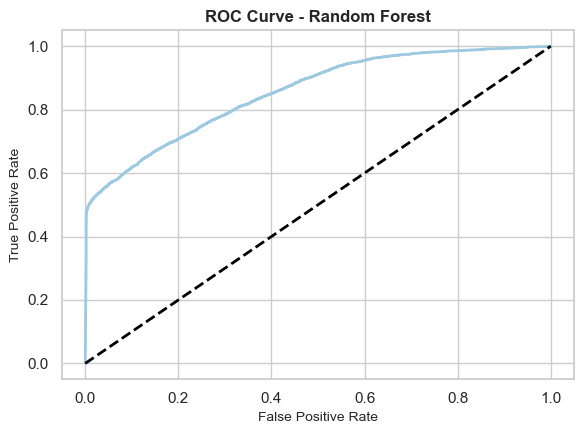

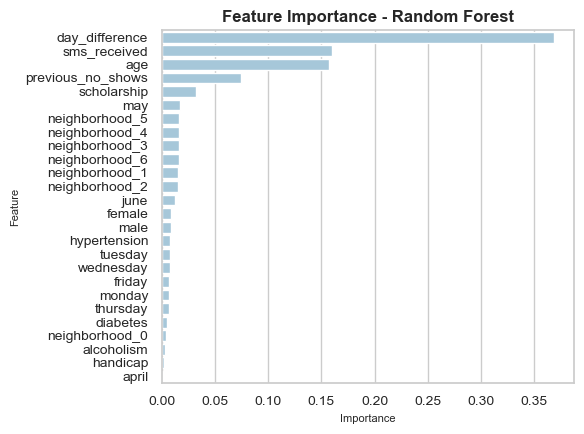

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize random forest model
rfc = RandomForestClassifier(random_state = 999)

# Define hyperparameter options for tuning
parameter_options = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize k-fold cross-validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 999)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = parameter_options,
    n_iter = 10,
    cv = kf,
    scoring = 'f1',
    verbose = 1,
    random_state = 999,
    n_jobs = -1
)

# Fit model and get best model
random_search.fit(X_train, y_train)
best_rfc = random_search.best_estimator_
print("\nBest Hyperparameters:", random_search.best_params_)

# Make predictions on the test set
y_pred = best_rfc.predict(X_test)
proba = best_rfc.predict_proba(X_test)[:, 1]

# Evaluate metrics across different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print("\nTest Metrics Across Classification Thresholds:")
for threshold in thresholds:
    y_pred = (proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)

    if threshold == 0.5:
        print(f"\033[31mThreshold {threshold:.1f} - Accuracy {accuracy:.3f}, "
              f"Precision {precision:.3f}, Recall {recall:.3f}, "
              f"F1 Score {f1:.3f}, AUC-ROC {auc_roc:.3f}\033[0m")
    else:
        print(f"Threshold {threshold:.1f} - Accuracy {accuracy:.3f}, "
              f"Precision {precision:.3f}, Recall {recall:.3f}, "
              f"F1 Score {f1:.3f}, AUC-ROC {auc_roc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
sns.set(style = "whitegrid")
plt.figure(figsize = (6, 4.5))

plt.plot(fpr, tpr, color = '#9ECAE1', linewidth = 2, label = f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--', linewidth = 2)
plt.title('ROC Curve - Random Forest', fontsize = 12, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 10)
plt.ylabel('True Positive Rate', fontsize = 10)

plt.tight_layout()
plt.show()

# Get feature importance
importance = best_rfc.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

# Plot feature importance
plt.figure(figsize = (6, 4.5))
sns.barplot(data = importance_df, x = 'Importance', y = 'Feature', color = '#9ECAE1', legend = False)
plt.title('Feature Importance - Random Forest', fontsize = 12, weight = 'bold')
plt.xlabel('Importance', fontsize = 8)
plt.ylabel('Feature', fontsize = 8)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.tight_layout()
plt.show()